<a href="https://colab.research.google.com/github/SanjanaS183/Cifar-10-Image-classification/blob/main/deep_learning_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#Task 1 - Read dataset and create dataloaders

In [ ]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['train', 'test']
['deer', 'automobile', 'horse', 'bird', 'cat', 'frog', 'ship', 'airplane', 'dog', 'truck']


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
batch_size = 128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

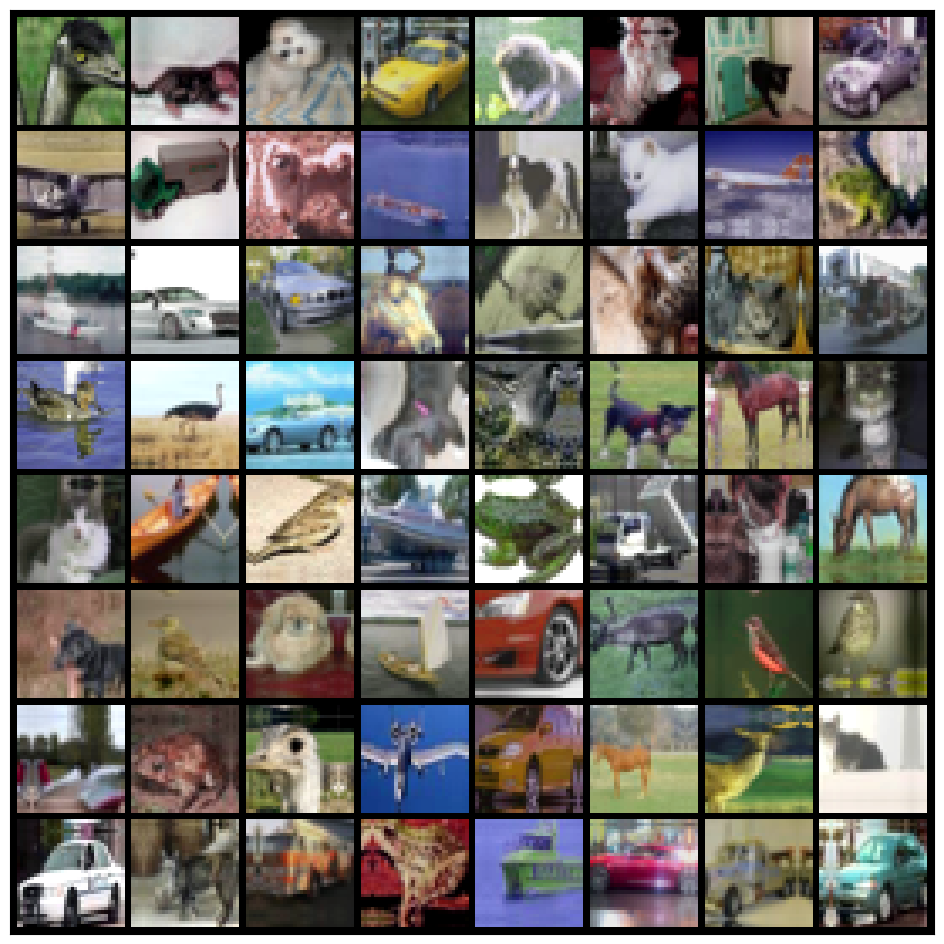

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)   # Calculate loss
        return {'Training_loss': loss, 'Training_acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['Training_loss'],result['Training_acc'], result['val_loss'], result['val_acc']))

#Task 2 - create the model

In [ ]:

class Cifar_Block(ImageClassificationBase):
    def __init__(self, in_channels,out_channels,num_classes=10):
        super(Cifar_Block,self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.Linear1=nn.Linear(in_channels, out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )



    def forward(self, x):

        a=self.avgpool(x)
        a=a.view(a.size(0),-1)
        a=self.Linear1((a))
        a = self.relu(a)
        a=self.dropout(a)


        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        output = a.unsqueeze(-1).unsqueeze(-1)* out1 + a.unsqueeze(-1).unsqueeze(-1)* out2 + a.unsqueeze(-1).unsqueeze(-1)* out3
        return output

class cifar10_block(ImageClassificationBase):
  def __init__(self):
    super(cifar10_block,self).__init__()
    self.block1=Cifar_Block(3,16)
    self.block2=Cifar_Block(16,64)
    self.block3=Cifar_Block(64,256)
    self.Linear2=nn.Linear(256*32*32,128)
    self.dropout = nn.Dropout(p=0.1)
    self.Linear3=nn.Linear(128,32)
    self.dropout = nn.Dropout(p=0.1)
    self.Linear4=nn.Linear(32,10)

  def forward(self,x):
    block_1=self.block1(x)
    block_2=self.block2(block_1)
    block_3=self.block3(block_2)
    linear2=self.Linear2(block_3.view(block_3.size(0),-1))
    a=self.dropout(linear2)
    linear3=self.Linear3(a)
    a=self.dropout(linear3)
    linear4=self.Linear4(a)
    return linear4


# Create an instance of the module
model = cifar10_block()


In [ ]:
model = to_device(cifar10_block(), device)
model

cifar10_block(
  (block1): Cifar_Block(
    (avgpool): AdaptiveAvgPool2d(output_size=1)
    (Linear1): Linear(in_features=3, out_features=16, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (block

#Task3 - create the loss and optimiser

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay, grad_clip, opt_func):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_accs = []
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss_dict = model.training_step(batch)
            loss = loss_dict['Training_loss']
            acc = loss_dict['Training_acc']
            train_losses.append(loss)
            train_accs.append(acc)
            model.zero_grad()
            loss.backward()


            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['Training_loss'] = torch.stack(train_losses).mean().item()
        result['Training_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3149421215057373, 'val_acc': 0.09814453125}]

In [ ]:
epochs = 100
max_lr = 0.001
grad_clip = 1
weight_decay = 0.0001
opt_func = torch.optim.Adam

#Task4 - Training the model

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00004, train_loss: 2.5416, train_acc: 0.1887, val_loss: 2.0441, val_acc: 0.2775
Epoch [1], last_lr: 0.00005, train_loss: 2.0880, train_acc: 0.2605, val_loss: 1.8841, val_acc: 0.3385
Epoch [2], last_lr: 0.00006, train_loss: 1.9672, train_acc: 0.2983, val_loss: 1.7531, val_acc: 0.3818
Epoch [3], last_lr: 0.00008, train_loss: 1.8957, train_acc: 0.3229, val_loss: 1.6576, val_acc: 0.4127
Epoch [4], last_lr: 0.00010, train_loss: 1.8189, train_acc: 0.3460, val_loss: 1.5747, val_acc: 0.4411
Epoch [5], last_lr: 0.00013, train_loss: 1.7433, train_acc: 0.3712, val_loss: 1.5192, val_acc: 0.4514
Epoch [6], last_lr: 0.00016, train_loss: 1.6913, train_acc: 0.3911, val_loss: 1.4556, val_acc: 0.4746
Epoch [7], last_lr: 0.00020, train_loss: 1.6402, train_acc: 0.4109, val_loss: 1.3957, val_acc: 0.4957
Epoch [8], last_lr: 0.00024, train_loss: 1.5911, train_acc: 0.4264, val_loss: 1.3232, val_acc: 0.5266
Epoch [9], last_lr: 0.00028, train_loss: 1.5446, train_acc: 0.4436, val_loss: 1.31

#Graph of training accuracies

Text(0.5, 1.0, 'Training accuracy vs No of epochs')

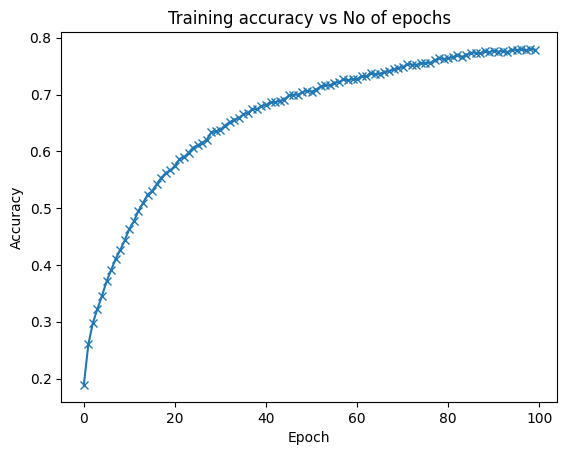

In [ ]:
Train_acc = []
for dict in history:
    if 'Training_acc' in dict:
        Train_acc.append(dict['Training_acc'])
plt.plot(Train_acc, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs No of epochs')

#Graph of validation accuracies

Text(0.5, 1.0, 'Validation accuracy vs No of epochs')

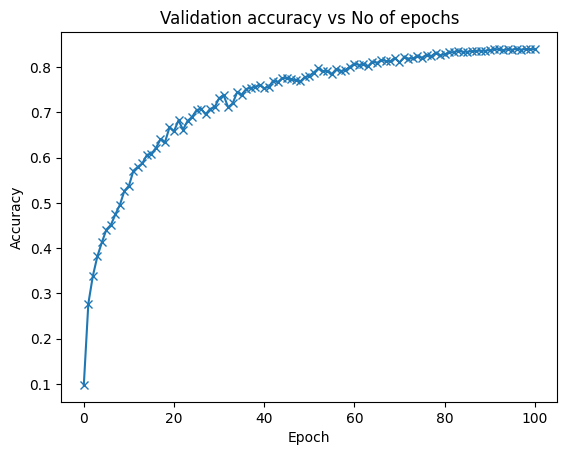

In [ ]:
Val_acc =[x['val_acc'] for x in history]
plt.plot(Val_acc,'-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy vs No of epochs')

#Graph of training and validation losses

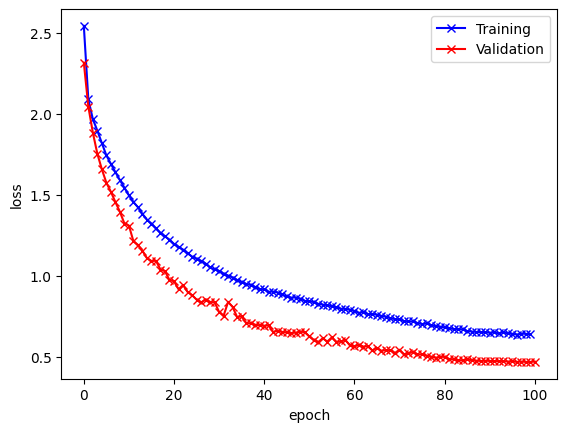

In [ ]:
import matplotlib.pyplot as plt

Train_loss = []
for dict in history:
    if 'Training_loss' in dict:
        Train_loss.append(dict['Training_loss'])
Val_losses = [x['val_loss'] for x in history]
plt.plot(Train_loss, '-bx')
plt.plot(Val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])